# Poisson Process: Beyond the Distribution

This notebook demonstrates what the **Poisson process** can model that the Poisson distribution alone cannot.

## Key Insight

- **Poisson distribution**: Counts in a fixed interval
- **Poisson process**: Event timing + counts as a consequence

## Table of Contents

1. [Simulating a Poisson Process](#1-simulating-a-poisson-process)
2. [Visualizing Event Times](#2-visualizing-event-times)
3. [Inter-Arrival Times are Exponential](#3-inter-arrival-times-are-exponential)
4. [Waiting Time for k Events (Gamma)](#4-waiting-time-for-k-events-gamma)
5. [Memorylessness in Action](#5-memorylessness-in-action)
6. [What the Process Gives You](#6-what-the-process-gives-you)
7. [Application: Mutation Accumulation](#7-application-mutation-accumulation)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

np.random.seed(42)

## 1. Simulating a Poisson Process

There are two equivalent ways to simulate a Poisson process:

1. **Via inter-arrival times**: Generate Exponential waiting times and cumsum
2. **Via counts**: Generate Poisson count, then uniformly distribute events

Method 1 is more natural and gives us the event times directly.

> 📖 **See also:** `03_simulation_methods.md` for the mathematical foundations behind both methods, including proofs of why they're equivalent.

In [3]:
def simulate_poisson_process(rate, T, method='exponential'):
    """
    Simulate a Poisson process with given rate over [0, T].
    
    Parameters
    ----------
    rate : float
        Events per unit time (λ)
    T : float
        Time horizon
    method : str
        'exponential' or 'uniform'
    
    Returns
    -------
    event_times : array
        Times at which events occur
    """
    if method == 'exponential':
        # Method 1: Generate exponential inter-arrival times
        event_times = []
        t = 0
        while True:
            # Time until next event ~ Exponential(rate)
            wait = np.random.exponential(1/rate)
            t += wait
            if t > T:
                break
            event_times.append(t)
        return np.array(event_times)
    
    elif method == 'uniform':
        # Method 2: Generate count, then uniform times
        n_events = np.random.poisson(rate * T)
        event_times = np.sort(np.random.uniform(0, T, n_events))
        return event_times

# Example: rate = 5 events/hour, observe for 10 hours
rate = 5
T = 10

events_exp = simulate_poisson_process(rate, T, method='exponential')
events_unif = simulate_poisson_process(rate, T, method='uniform')

print(f"Method 1 (Exponential): {len(events_exp)} events")
print(f"Method 2 (Uniform):     {len(events_unif)} events")
print(f"Expected:               {rate * T} events")

Method 1 (Exponential): 52 events
Method 2 (Uniform):     60 events
Expected:               50 events


## 2. Visualizing Event Times

The Poisson process gives us **when** events happen, not just **how many**.

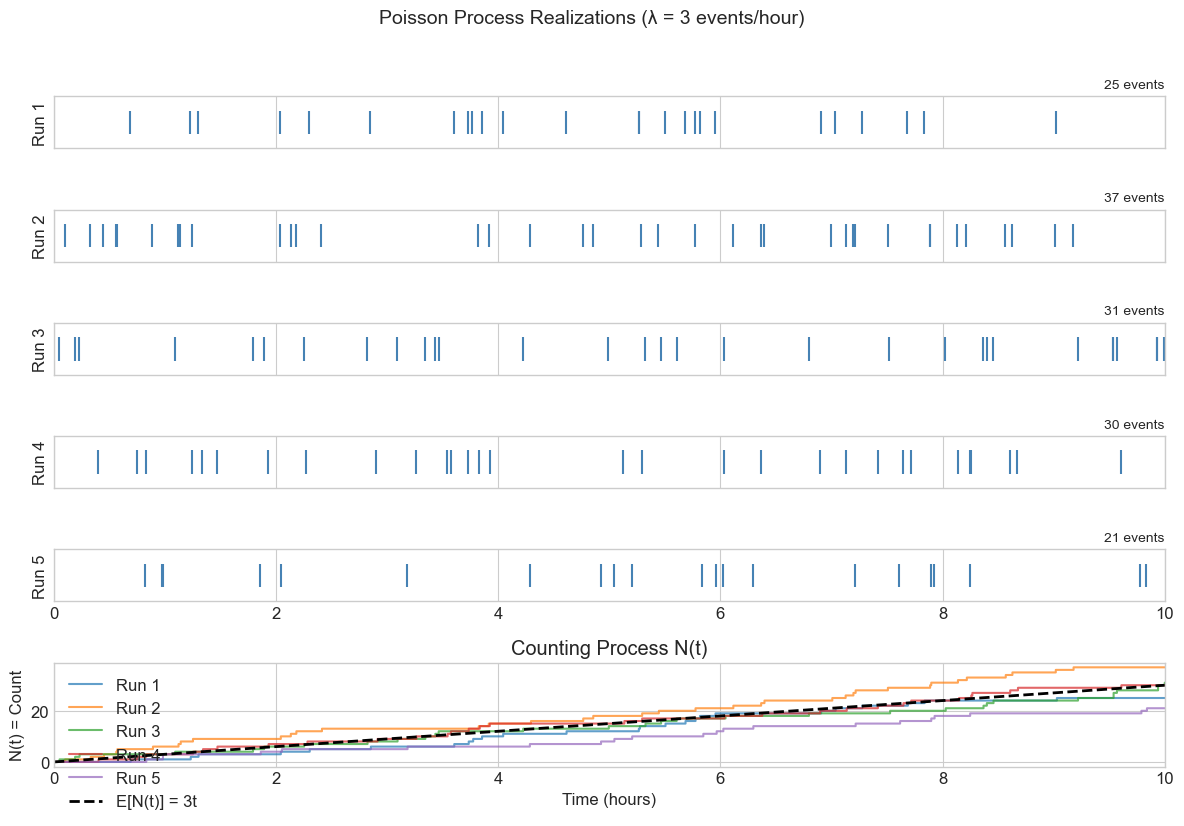


Key observation: Same rate, different event times each run.
The PROCESS gives us timing; the DISTRIBUTION only gives counts.


In [4]:
# Simulate multiple realizations
n_realizations = 5
rate = 3  # events per hour
T = 10    # hours

fig, axes = plt.subplots(n_realizations + 1, 1, figsize=(12, 8), 
                         gridspec_kw={'height_ratios': [1]*n_realizations + [2]})

all_events = []
for i in range(n_realizations):
    events = simulate_poisson_process(rate, T)
    all_events.append(events)
    
    # Plot event times as vertical lines
    axes[i].eventplot([events], colors='steelblue', linewidths=1.5)
    axes[i].set_xlim(0, T)
    axes[i].set_ylabel(f'Run {i+1}')
    axes[i].set_yticks([])
    axes[i].set_title(f'{len(events)} events' if i == 0 else f'{len(events)} events', 
                      loc='right', fontsize=10)
    if i < n_realizations - 1:
        axes[i].set_xticklabels([])

# Bottom plot: counting process N(t)
ax = axes[-1]
t_grid = np.linspace(0, T, 1000)
for i, events in enumerate(all_events):
    N_t = np.array([np.sum(events <= t) for t in t_grid])
    ax.step(t_grid, N_t, where='post', alpha=0.7, label=f'Run {i+1}')

ax.plot(t_grid, rate * t_grid, 'k--', lw=2, label=f'E[N(t)] = {rate}t')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('N(t) = Count')
ax.set_title('Counting Process N(t)')
ax.legend(loc='upper left')
ax.set_xlim(0, T)

plt.suptitle(f'Poisson Process Realizations (λ = {rate} events/hour)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nKey observation: Same rate, different event times each run.")
print("The PROCESS gives us timing; the DISTRIBUTION only gives counts.")

## 3. Inter-Arrival Times are Exponential

A fundamental property: the waiting time between consecutive events follows an Exponential distribution.

$$T_i \sim \text{Exponential}(\lambda)$$

with mean $1/\lambda$.

In [5]:
# Simulate many events to get inter-arrival times
rate = 5
T = 1000  # Long time to get many events

events = simulate_poisson_process(rate, T)
inter_arrivals = np.diff(events)  # Time between consecutive events

print(f"Number of events: {len(events)}")
print(f"Number of inter-arrival times: {len(inter_arrivals)}")
print(f"\nInter-arrival time statistics:")
print(f"  Sample mean:     {inter_arrivals.mean():.4f}")
print(f"  Theoretical mean: {1/rate:.4f} (= 1/λ)")
print(f"  Sample std:      {inter_arrivals.std():.4f}")
print(f"  Theoretical std:  {1/rate:.4f} (= 1/λ)")

Number of events: 5053
Number of inter-arrival times: 5052

Inter-arrival time statistics:
  Sample mean:     0.1978
  Theoretical mean: 0.2000 (= 1/λ)
  Sample std:      0.1971
  Theoretical std:  0.2000 (= 1/λ)


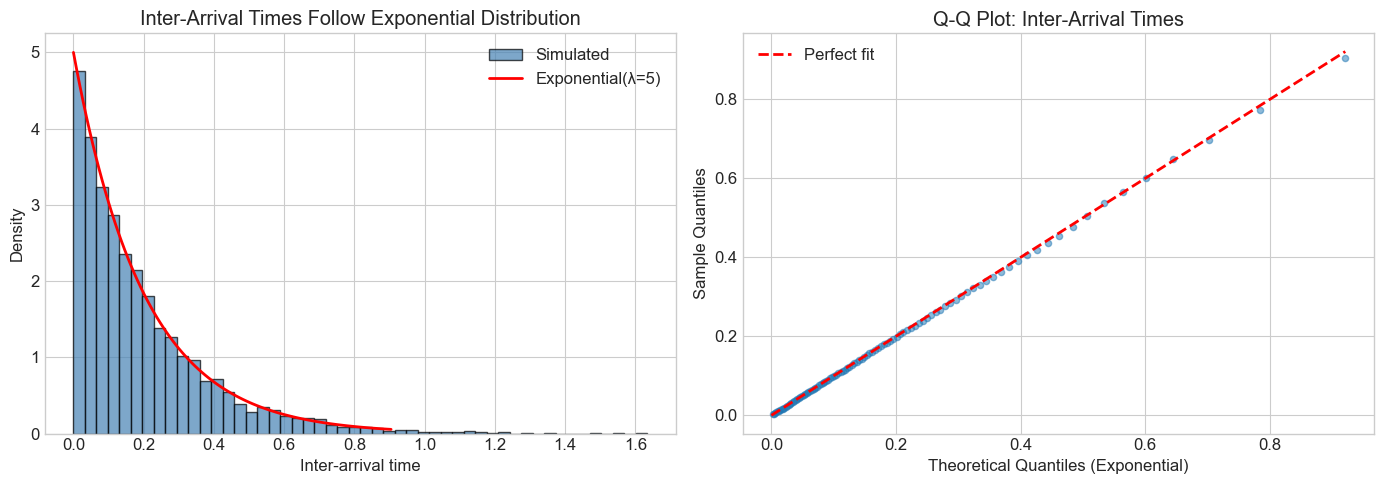

In [6]:
# Visualize: histogram vs theoretical exponential
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of inter-arrival times
x = np.linspace(0, np.percentile(inter_arrivals, 99), 100)
exp_pdf = stats.expon.pdf(x, scale=1/rate)

axes[0].hist(inter_arrivals, bins=50, density=True, alpha=0.7, 
             color='steelblue', edgecolor='black', label='Simulated')
axes[0].plot(x, exp_pdf, 'r-', lw=2, label=f'Exponential(λ={rate})')
axes[0].set_xlabel('Inter-arrival time')
axes[0].set_ylabel('Density')
axes[0].set_title('Inter-Arrival Times Follow Exponential Distribution')
axes[0].legend()

# Q-Q plot
theoretical_quantiles = stats.expon.ppf(np.linspace(0.01, 0.99, 100), scale=1/rate)
sample_quantiles = np.percentile(inter_arrivals, np.linspace(1, 99, 100))

axes[1].scatter(theoretical_quantiles, sample_quantiles, alpha=0.5, s=20)
max_val = max(theoretical_quantiles.max(), sample_quantiles.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect fit')
axes[1].set_xlabel('Theoretical Quantiles (Exponential)')
axes[1].set_ylabel('Sample Quantiles')
axes[1].set_title('Q-Q Plot: Inter-Arrival Times')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Waiting Time for k Events (Gamma)

The time until the k-th event is the sum of k exponential waiting times:

$$S_k = T_1 + T_2 + \cdots + T_k \sim \text{Gamma}(k, 1/\lambda)$$

This connects the Poisson process to the Gamma distribution!

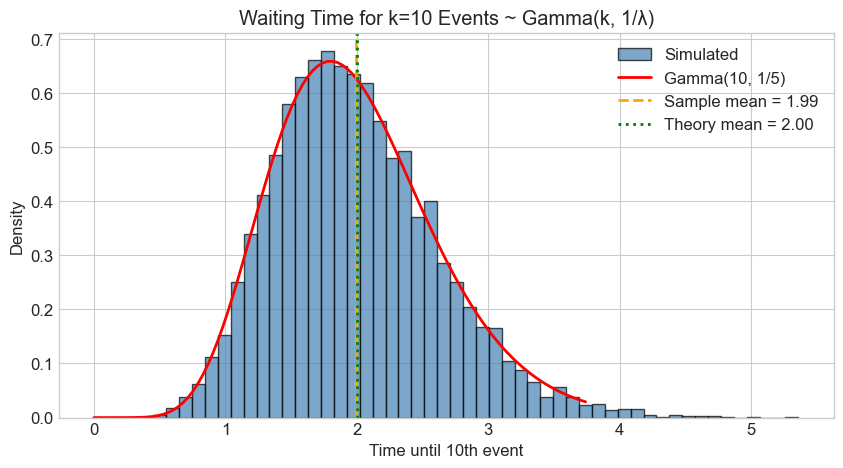

Waiting time for 10th event:
  Sample mean:      1.9931
  Theoretical mean: 2.0000 (= k/λ)
  Sample variance:  0.3879
  Theoretical var:  0.4000 (= k/λ²)


In [7]:
# Simulate waiting time for k-th event
rate = 5
k = 10  # Wait for 10th event
n_simulations = 10000

waiting_times = []
for _ in range(n_simulations):
    # Generate k exponential inter-arrival times and sum them
    inter_arrivals = np.random.exponential(1/rate, k)
    waiting_times.append(inter_arrivals.sum())

waiting_times = np.array(waiting_times)

# Compare with Gamma distribution
x = np.linspace(0, np.percentile(waiting_times, 99), 100)
gamma_pdf = stats.gamma.pdf(x, a=k, scale=1/rate)

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(waiting_times, bins=50, density=True, alpha=0.7, 
        color='steelblue', edgecolor='black', label='Simulated')
ax.plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma({k}, 1/{rate})')
ax.axvline(waiting_times.mean(), color='orange', linestyle='--', 
           lw=2, label=f'Sample mean = {waiting_times.mean():.2f}')
ax.axvline(k/rate, color='green', linestyle=':', 
           lw=2, label=f'Theory mean = {k/rate:.2f}')

ax.set_xlabel(f'Time until {k}th event')
ax.set_ylabel('Density')
ax.set_title(f'Waiting Time for k={k} Events ~ Gamma(k, 1/λ)')
ax.legend()

plt.show()

print(f"Waiting time for {k}th event:")
print(f"  Sample mean:      {waiting_times.mean():.4f}")
print(f"  Theoretical mean: {k/rate:.4f} (= k/λ)")
print(f"  Sample variance:  {waiting_times.var():.4f}")
print(f"  Theoretical var:  {k/rate**2:.4f} (= k/λ²)")

## 5. Memorylessness in Action

The exponential distribution is **memoryless**:

$$P(T > s + t \mid T > s) = P(T > t)$$

This means: if you've already waited $s$ time units, your remaining wait time distribution is unchanged.

**This is something the Poisson distribution alone cannot express!**

In [8]:
# Demonstrate memorylessness
rate = 2  # events per hour
n_simulations = 100000

# Generate exponential waiting times
waiting_times = np.random.exponential(1/rate, n_simulations)

# Condition: already waited s = 0.5 hours
s = 0.5

# Filter to cases where we waited more than s
survived = waiting_times[waiting_times > s]
remaining_wait = survived - s  # Remaining time after s

print(f"Memorylessness demonstration (λ = {rate}):")
print(f"\nUnconditional waiting time:")
print(f"  Mean: {waiting_times.mean():.4f}")
print(f"  Std:  {waiting_times.std():.4f}")
print(f"\nRemaining wait | already waited {s} hours:")
print(f"  Mean: {remaining_wait.mean():.4f}")
print(f"  Std:  {remaining_wait.std():.4f}")
print(f"\nTheoretical (both should be 1/λ = {1/rate:.4f})")

Memorylessness demonstration (λ = 2):

Unconditional waiting time:
  Mean: 0.5018
  Std:  0.5016

Remaining wait | already waited 0.5 hours:
  Mean: 0.5013
  Std:  0.5015

Theoretical (both should be 1/λ = 0.5000)


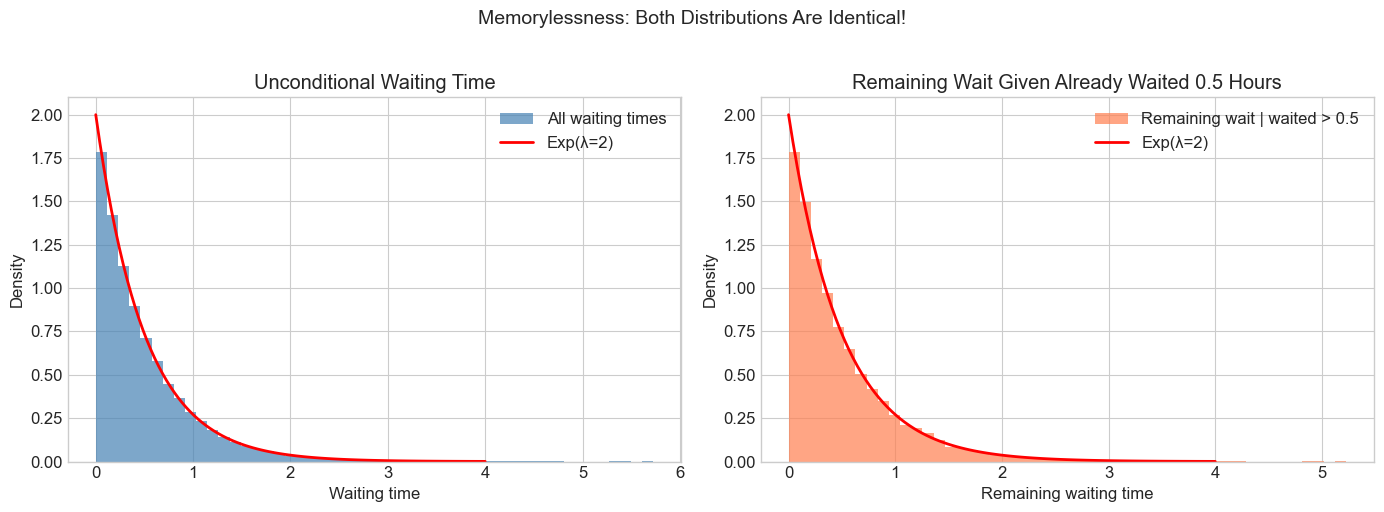


→ The remaining wait time has the SAME distribution as the original!
→ The system has 'no memory' of how long you've already waited.


In [9]:
# Visualize memorylessness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.linspace(0, 4, 100)
exp_pdf = stats.expon.pdf(x, scale=1/rate)

# Unconditional distribution
axes[0].hist(waiting_times, bins=50, density=True, alpha=0.7, 
             color='steelblue', label='All waiting times')
axes[0].plot(x, exp_pdf, 'r-', lw=2, label=f'Exp(λ={rate})')
axes[0].set_xlabel('Waiting time')
axes[0].set_ylabel('Density')
axes[0].set_title('Unconditional Waiting Time')
axes[0].legend()

# Conditional distribution (remaining wait)
axes[1].hist(remaining_wait, bins=50, density=True, alpha=0.7, 
             color='coral', label=f'Remaining wait | waited > {s}')
axes[1].plot(x, exp_pdf, 'r-', lw=2, label=f'Exp(λ={rate})')
axes[1].set_xlabel('Remaining waiting time')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Remaining Wait Given Already Waited {s} Hours')
axes[1].legend()

plt.suptitle('Memorylessness: Both Distributions Are Identical!', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n→ The remaining wait time has the SAME distribution as the original!")
print("→ The system has 'no memory' of how long you've already waited.")

## 6. What the Process Gives You

Let's directly compare what questions we can answer with:
- The Poisson **distribution** alone
- The Poisson **process**

In [10]:
rate = 12  # customers per hour
T = 1      # 1 hour

print("="*60)
print("QUESTIONS THE DISTRIBUTION CAN ANSWER")
print("="*60)

# Q1: Expected count
expected = rate * T
print(f"\nQ: Expected customers in {T} hour?")
print(f"A: E[N({T})] = λT = {expected}")

# Q2: Probability of specific count
k = 15
prob = stats.poisson.pmf(k, rate * T)
print(f"\nQ: P(exactly {k} customers in {T} hour)?")
print(f"A: P(N({T}) = {k}) = {prob:.4f}")

# Q3: Variance
var = rate * T
print(f"\nQ: Variance of customer count?")
print(f"A: Var[N({T})] = λT = {var}")

QUESTIONS THE DISTRIBUTION CAN ANSWER

Q: Expected customers in 1 hour?
A: E[N(1)] = λT = 12

Q: P(exactly 15 customers in 1 hour)?
A: P(N(1) = 15) = 0.0724

Q: Variance of customer count?
A: Var[N(1)] = λT = 12


In [11]:
print("="*60)
print("QUESTIONS ONLY THE PROCESS CAN ANSWER")
print("="*60)

# Q4: When do events occur?
events = simulate_poisson_process(rate, T)
print(f"\nQ: When do customers arrive?")
print(f"A: Event times (hours): {events[:5].round(3)}... ({len(events)} total)")

# Q5: Distribution of inter-arrival times
print(f"\nQ: How long between customers on average?")
print(f"A: Inter-arrival ~ Exp(λ), mean = 1/λ = {1/rate*60:.1f} minutes")

# Q6: Conditional probability (memorylessness)
print(f"\nQ: Given no customer in last 10 min, expected wait for next?")
print(f"A: Still Exp(λ), mean = {1/rate*60:.1f} min (memoryless!)")

# Q7: Time until k-th event
k = 5
print(f"\nQ: Distribution of time until {k}th customer?")
print(f"A: Gamma({k}, 1/λ), mean = {k/rate*60:.1f} minutes")

# Q8: Simulate realistic arrival stream
print(f"\nQ: Simulate a realistic arrival stream for queueing analysis?")
print(f"A: Generate exponential inter-arrivals, cumsum for event times")

QUESTIONS ONLY THE PROCESS CAN ANSWER

Q: When do customers arrive?
A: Event times (hours): [0.009 0.041 0.041 0.352 0.367]... (18 total)

Q: How long between customers on average?
A: Inter-arrival ~ Exp(λ), mean = 1/λ = 5.0 minutes

Q: Given no customer in last 10 min, expected wait for next?
A: Still Exp(λ), mean = 5.0 min (memoryless!)

Q: Distribution of time until 5th customer?
A: Gamma(5, 1/λ), mean = 25.0 minutes

Q: Simulate a realistic arrival stream for queueing analysis?
A: Generate exponential inter-arrivals, cumsum for event times


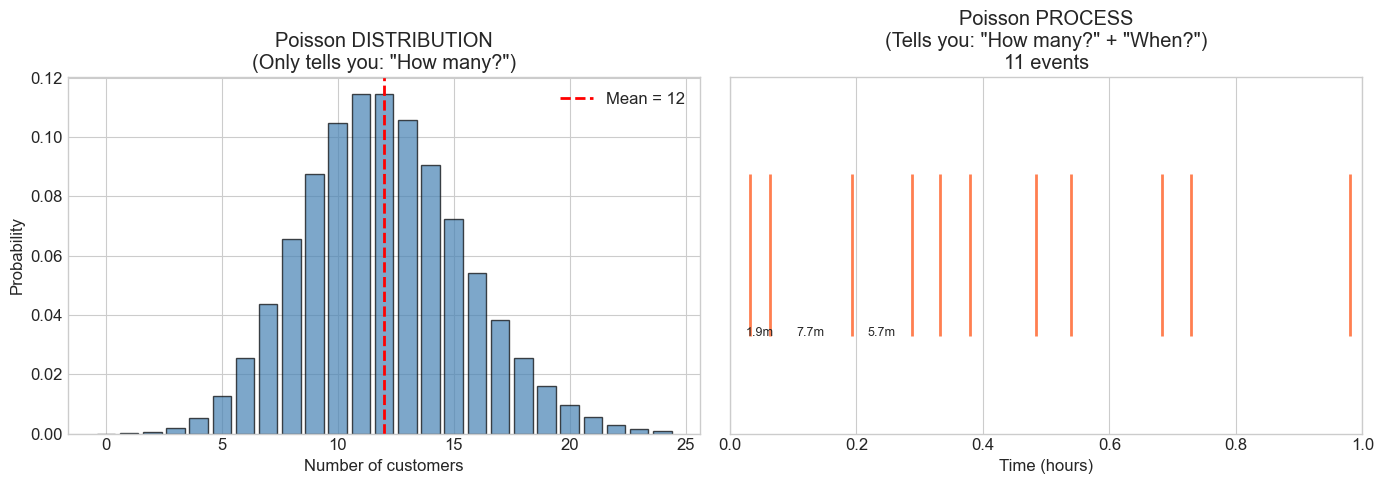

In [12]:
# Visual: Distribution vs Process
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: What the distribution gives you (count probabilities)
k_vals = np.arange(0, 25)
pmf = stats.poisson.pmf(k_vals, rate * T)

axes[0].bar(k_vals, pmf, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(rate * T, color='red', linestyle='--', lw=2, label=f'Mean = {rate*T}')
axes[0].set_xlabel('Number of customers')
axes[0].set_ylabel('Probability')
axes[0].set_title('Poisson DISTRIBUTION\n(Only tells you: "How many?")')
axes[0].legend()

# Right: What the process gives you (event times)
events = simulate_poisson_process(rate, T)
axes[1].eventplot([events], colors='coral', linewidths=2)
axes[1].set_xlim(0, T)
axes[1].set_xlabel('Time (hours)')
axes[1].set_yticks([])
axes[1].set_title(f'Poisson PROCESS\n(Tells you: "How many?" + "When?")\n{len(events)} events')

# Add inter-arrival annotations
if len(events) > 1:
    for i in range(min(3, len(events)-1)):
        gap = events[i+1] - events[i]
        mid = (events[i] + events[i+1]) / 2
        axes[1].annotate(f'{gap*60:.1f}m', xy=(mid, 0.5), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Application: Mutation Accumulation in Cancer

A practical example showing why the process matters in biology.

**Scenario:** Somatic mutations accumulate during cell divisions. We want to model:
1. How many mutations after N cell cycles?
2. When did each mutation occur?
3. What's the distribution of "mutation age"?

In [13]:
# Mutation accumulation model
mutation_rate = 0.1  # mutations per cell cycle
n_cycles = 100       # cell cycles (e.g., tumor development)
n_cells = 1000       # simulate many cells

# For each cell, simulate mutation process
all_mutation_times = []
mutation_counts = []

for _ in range(n_cells):
    # Simulate Poisson process for this cell
    mutations = simulate_poisson_process(mutation_rate, n_cycles)
    all_mutation_times.extend(mutations)
    mutation_counts.append(len(mutations))

mutation_counts = np.array(mutation_counts)
all_mutation_times = np.array(all_mutation_times)

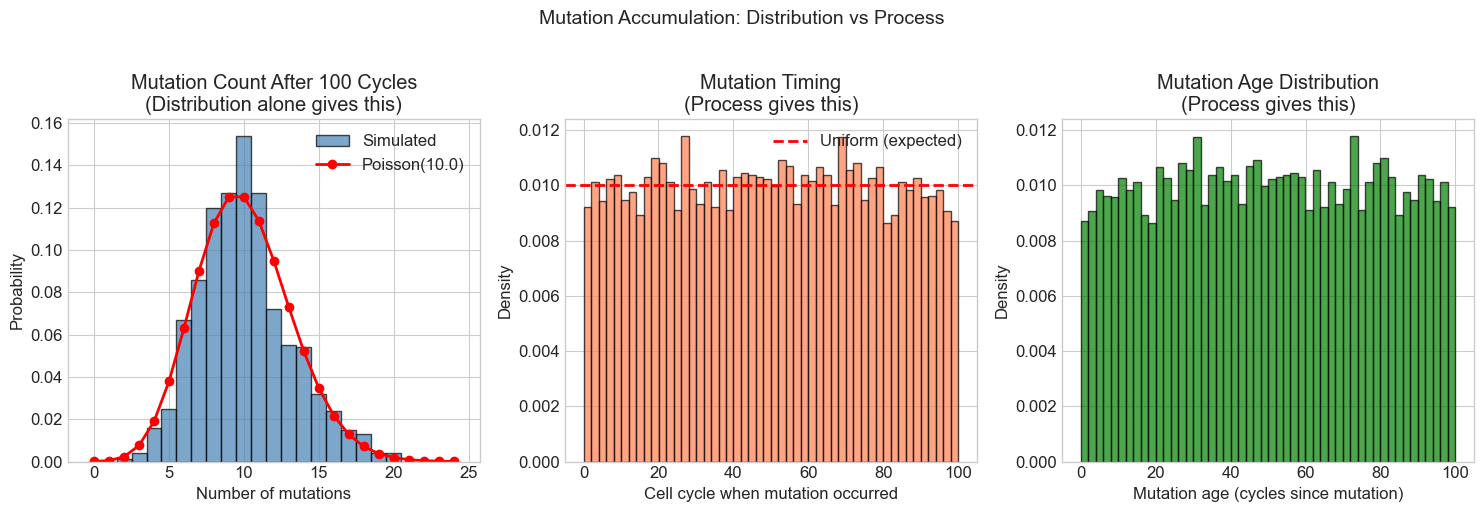

Summary statistics:
  Mean mutations per cell: 10.09 (expected: 10.0)
  Mean mutation age: 50.2 cycles
  Oldest mutation: 100.0 cycles
  Newest mutation: 0.0 cycles


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Mutation count distribution (what distribution gives you)
k_vals = np.arange(0, 25)
theoretical_pmf = stats.poisson.pmf(k_vals, mutation_rate * n_cycles)

axes[0].hist(mutation_counts, bins=np.arange(-0.5, 25.5, 1), density=True, 
             alpha=0.7, color='steelblue', edgecolor='black', label='Simulated')
axes[0].plot(k_vals, theoretical_pmf, 'ro-', lw=2, markersize=6, 
             label=f'Poisson({mutation_rate * n_cycles})')
axes[0].set_xlabel('Number of mutations')
axes[0].set_ylabel('Probability')
axes[0].set_title(f'Mutation Count After {n_cycles} Cycles\n(Distribution alone gives this)')
axes[0].legend()

# 2. When mutations occur (what process gives you)
axes[1].hist(all_mutation_times, bins=50, density=True, 
             alpha=0.7, color='coral', edgecolor='black')
axes[1].axhline(1/n_cycles, color='red', linestyle='--', lw=2, 
                label='Uniform (expected)')
axes[1].set_xlabel('Cell cycle when mutation occurred')
axes[1].set_ylabel('Density')
axes[1].set_title('Mutation Timing\n(Process gives this)')
axes[1].legend()

# 3. Mutation "age" at observation time
mutation_ages = n_cycles - all_mutation_times  # How old is each mutation?

axes[2].hist(mutation_ages, bins=50, density=True, 
             alpha=0.7, color='green', edgecolor='black')
axes[2].set_xlabel('Mutation age (cycles since mutation)')
axes[2].set_ylabel('Density')
axes[2].set_title('Mutation Age Distribution\n(Process gives this)')

plt.suptitle('Mutation Accumulation: Distribution vs Process', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Summary statistics:")
print(f"  Mean mutations per cell: {mutation_counts.mean():.2f} (expected: {mutation_rate * n_cycles})")
print(f"  Mean mutation age: {mutation_ages.mean():.1f} cycles")
print(f"  Oldest mutation: {mutation_ages.max():.1f} cycles")
print(f"  Newest mutation: {mutation_ages.min():.1f} cycles")

### Why This Matters for Cancer Biology

The **timing** of mutations is crucial for:

1. **Clonal evolution**: Early mutations are in more cells (founder mutations)
2. **Phylogenetic reconstruction**: Build tumor evolutionary trees
3. **Treatment timing**: When did resistance mutations arise?
4. **Prognosis**: Mutation burden vs mutation timing

The Poisson **distribution** tells you how many mutations.
The Poisson **process** tells you when they happened — essential for evolutionary analysis.

---

## Summary

### What the Poisson Process Adds Beyond the Distribution

| Capability | Distribution | Process |
|------------|--------------|--------|
| Count in interval | ✓ | ✓ |
| Event times | ✗ | ✓ |
| Inter-arrival distribution | ✗ | ✓ (Exponential) |
| Waiting time for k events | ✗ | ✓ (Gamma) |
| Conditional probabilities | ✗ | ✓ (Memoryless) |
| Simulation of event streams | ✗ | ✓ |

### Key Relationships

```
Poisson Process (rate λ)
        │
        ├── Counts in [0,t] → Poisson(λt)
        │
        ├── Inter-arrival times → Exponential(λ)
        │
        └── Time to k-th event → Gamma(k, 1/λ)
```

### The Mental Model

- **Distribution** = photograph (snapshot of counts)
- **Process** = video (full temporal dynamics)

---

## References

- See `01_distribution_vs_process.md` for conceptual explanation
- See `02_poisson_process_faq.md` for deeper questions
- See `02_gamma_distribution.ipynb` for the Gamma connection